## Calculate transformer temperatures with different initial conditions

The thermal model requires an initial value for top-oil temperature to begin calculations, since it bases future values on the previous state. Different initialization methods are available depending on the information you have about the transformer's operating state:

- **Cold start (default)**: Assumes the transformer begins at rest with no prior load. Both top-oil and hot-spot temperatures start at ambient temperature.
- **Known initial temperature**: Use this when you know the top-oil temperature at the first timestamp (from measurements).
- **Stabilized at load**: Use this when you know the steady-state load before the profile begins. The temperatures stabilize at the equilibrium values for that load.

This example demonstrates all three approaches using the `InitialTopOilTemp`, `InitialLoad`, and default initialization options.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import InputProfile, OutputProfile, UserTransformerSpecifications
from transformer_thermal_model.schemas.thermal_model.initial_state import InitialLoad, InitialTopOilTemp
from transformer_thermal_model.transformer import DistributionTransformer

In [2]:
datetime_index = [pd.to_datetime("2025-07-01 00:00:00") + pd.Timedelta(minutes=5 * i) for i in np.arange(0, 30)]

load_series = pd.Series(data=700, index=datetime_index)
ambient_series = pd.Series(data=20, index=datetime_index)

profile_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=load_series, ambient_temperature_profile=ambient_series
)

transformer_specifications = UserTransformerSpecifications(
    load_loss=5200,
    time_const_oil=10,
    nom_load_sec_side=900,
    no_load_loss=800,
    amb_temp_surcharge=10,
)
transformer = DistributionTransformer(user_specs=transformer_specifications)


def plot_temperature_profiles(results: OutputProfile):
    """Plot the temperature profiles from the model results."""
    plt.figure()
    ax = results.top_oil_temp_profile.plot(label="Top-oil temperature")
    results.hot_spot_temp_profile.plot(label="Hot-spot temperature")
    ambient_series.plot(label="Ambient temperature")
    ax.set_ylabel("Temperature [C]")
    ax.legend()
    plt.show()

### Initialize with a known initial top-oil temperature

Use `InitialTopOilTemp` when you have a direct measurement of the top-oil temperature at the first timestamp. This provides an accurate starting point for the temperature calculation.

**Note**: Since hot-spot temperature cannot be directly determined from top-oil temperature alone, the model assumes the hot-spot temperature also starts at this initial top-oil temperature. Once calculations begin, the hot-spot temperature will diverge based on the losses and thermal dynamics.

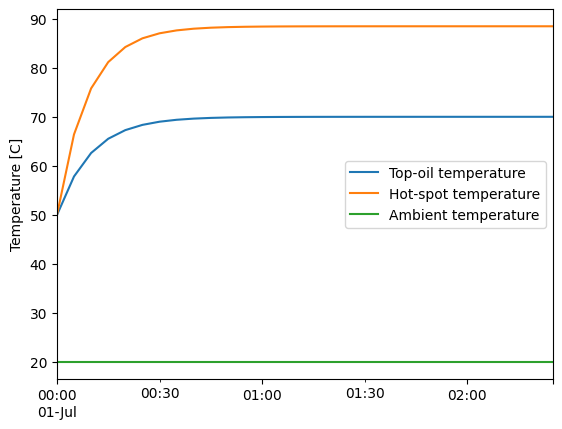

In [3]:
model = Model(
    temperature_profile=profile_input,
    transformer=transformer,
    initial_condition=InitialTopOilTemp(initial_top_oil_temp=50),
)
results = model.run()
plot_temperature_profiles(results)

### Initialize by stabilizing at a known load

Use `InitialLoad` when you know the transformer has been operating at a steady load before the profile begins. Both top-oil and hot-spot temperatures are calculated as if the transformer reached thermal equilibrium at that load. This provides realistic initial temperatures for the dynamic simulation that follows.

In this example, we assume the transformer was operating at 500 MW load, allowing both temperatures to stabilize at their steady-state values before the profile begins.

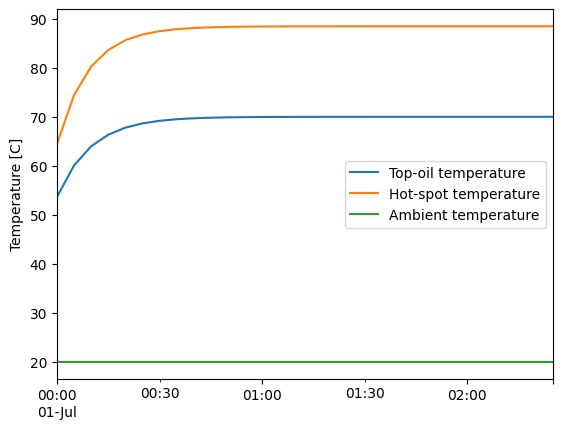

In [7]:
model = Model(
    temperature_profile=profile_input, transformer=transformer, initial_condition=InitialLoad(initial_load=500)
)
results = model.run()
plot_temperature_profiles(results)

### Cold start: No prior information (default behavior)

When you have no information about the transformer's previous operating state, or you know it started 'cold', the model performs a "cold start" by assuming the transformer begins at rest. Both top-oil and hot-spot temperatures start at the ambient temperature. 

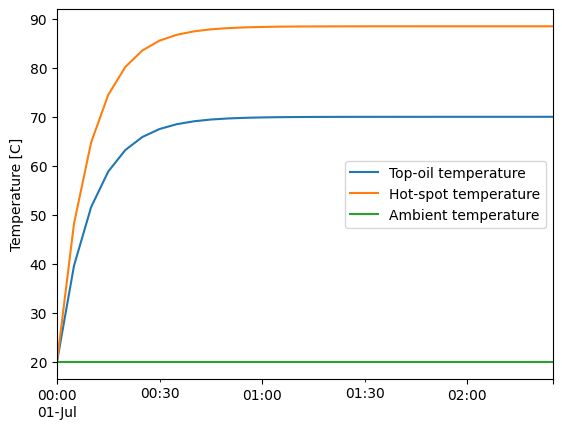

In [8]:
model = Model(temperature_profile=profile_input, transformer=transformer)
results = model.run()
plot_temperature_profiles(results)